##GAN&CLIP&GA - COS-SIM

Authors: Maciej Domagała, Adam Komorowski

### GENERATING IMAGES

In [5]:
#@title Initialization (Installation, Imports) - check github branch!
%%capture
import subprocess
import re

nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
version = re.findall("release (\d+\.\d+)", nvcc)[0]

pytorch_suffix = {
    "10.0": "+cu100",
    "10.1": "+cu101",
    "10.2": "",
}

pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

!git clone https://github.com/maciejdomagala/clip_gans.git
%cd clip_gans
!git checkout main ### WARNING!!!

try:
  import torch
except:
  !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

try:
  import torchvision
except:
  !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

!pip install pytorch_pretrained_biggan pymoo kornia ftfy tensorboard

# IMPORTS
import warnings

import argparse
import os
import torch
import numpy as np
import pickle
import math
from tqdm import tqdm_notebook
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request
import cv2

from config import get_config
from problem import GenerationProblem
from operators import get_operators, get_algo


warnings.filterwarnings('ignore')

In [6]:
#@title Input Parameters (Code will produce (population_size*number_of_loops) evaluation images)
target = "a pixel cat" #@param {type:"string"}
config = "DeepMindBigGAN256_ga" #@param ["DeepMindBigGAN256_ga","DeepMindBigGAN256_de", "StyleGAN2_ffhq_ga","StyleGAN2_ffhq_de", "StyleGAN2_car_ga", "StyleGAN2_car_de","StyleGAN2_church_ga", "StyleGAN2_church_de","StyleGAN2_cat_ga", "StyleGAN2_cat_de"]
generations =   20 #@param {type:"number"}
population_size = 64 #@param {type:"number"}
number_of_loops =  5 #@param {type:"number"}

In [7]:
#@title Download weights for given model
!chmod +x ./download-weights.sh
if "ffhq" in config:
  ! ./download-weights.sh StyleGAN2-ffhq
if "church" in config:
  ! ./download-weights.sh StyleGAN2-church
if "car" in config:
  ! ./download-weights.sh StyleGAN2-car
if "cat" in config:
  ! ./download-weights.sh StyleGAN2-cat

In [8]:
#@title Config 
config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    tmp_folder="./results"
)
vars(config).update(get_config(config.config))
config.pop_size = population_size
# config.algorithm = algorithm_param
config.generations = generations

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)
if not os.path.exists(f'{config.tmp_folder}/{config.target}'): os.mkdir(f'{config.tmp_folder}/{config.target}')

In [11]:
#@title Support methods

def split_into_tiles_and_save(image):
  """
  Method splits batch image from the Pymoo output to the equal tiles and save them
  to the results directory.
  """
  global config, iteration, loop, target
  M = int(image.shape[0]//math.sqrt(config.pop_size))
  N = int(image.shape[1]//math.sqrt(config.pop_size))
  tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
  tiles = [tile for tile in tiles if tile.shape == (M,N,3)]
  if not os.path.exists(f'{config.tmp_folder}/{config.target}/{loop}'): os.mkdir(f'{config.tmp_folder}/{config.target}/{loop}')
  for j, each in enumerate(tiles):
    cv2.imwrite(f'./{config.tmp_folder}/{config.target}/{loop}/{target}_loop_{loop}_id_{j}.jpg', each)

def callback(algorithm):
    global config, iteration, loop, target

    iteration += 1

    sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
    X = np.stack([p.X for p in sortedpop])      
    ls = config.latent(config)
    ls.set_from_population(X)

def generate_image(loop: int):
  problem = GenerationProblem(config)

  kwargs = get_algo(config)

  algorithm = get_algorithm(
      config.algorithm,
      callback=callback,
      **kwargs
  )

  res = minimize(
      problem,
      algorithm,
      ("n_gen", config.generations),
      save_history=False,
      verbose=False,
  )
  
  X = np.atleast_2d(res.X) # for config.n_obj==1
  ls = config.latent(config)
  ls.set_from_population(X)

  with torch.no_grad():
      generated = problem.generator.generate(ls)
  file_path = f"/content/clip_gans/{config.tmp_folder[2:]}/{config.target}/loop_{loop}.jpg"
  problem.generator.save(generated, file_path)

  return file_path,- res.F[0]

In [12]:
#@title RUN (GENERATE IMAGES)

cos_sim_dict = dict()

for loop in tqdm_notebook(range(number_of_loops)):
  iteration=0
  cos_sim_path, cos_sim_val = generate_image(loop)
  cos_sim_dict[cos_sim_path] = cos_sim_val

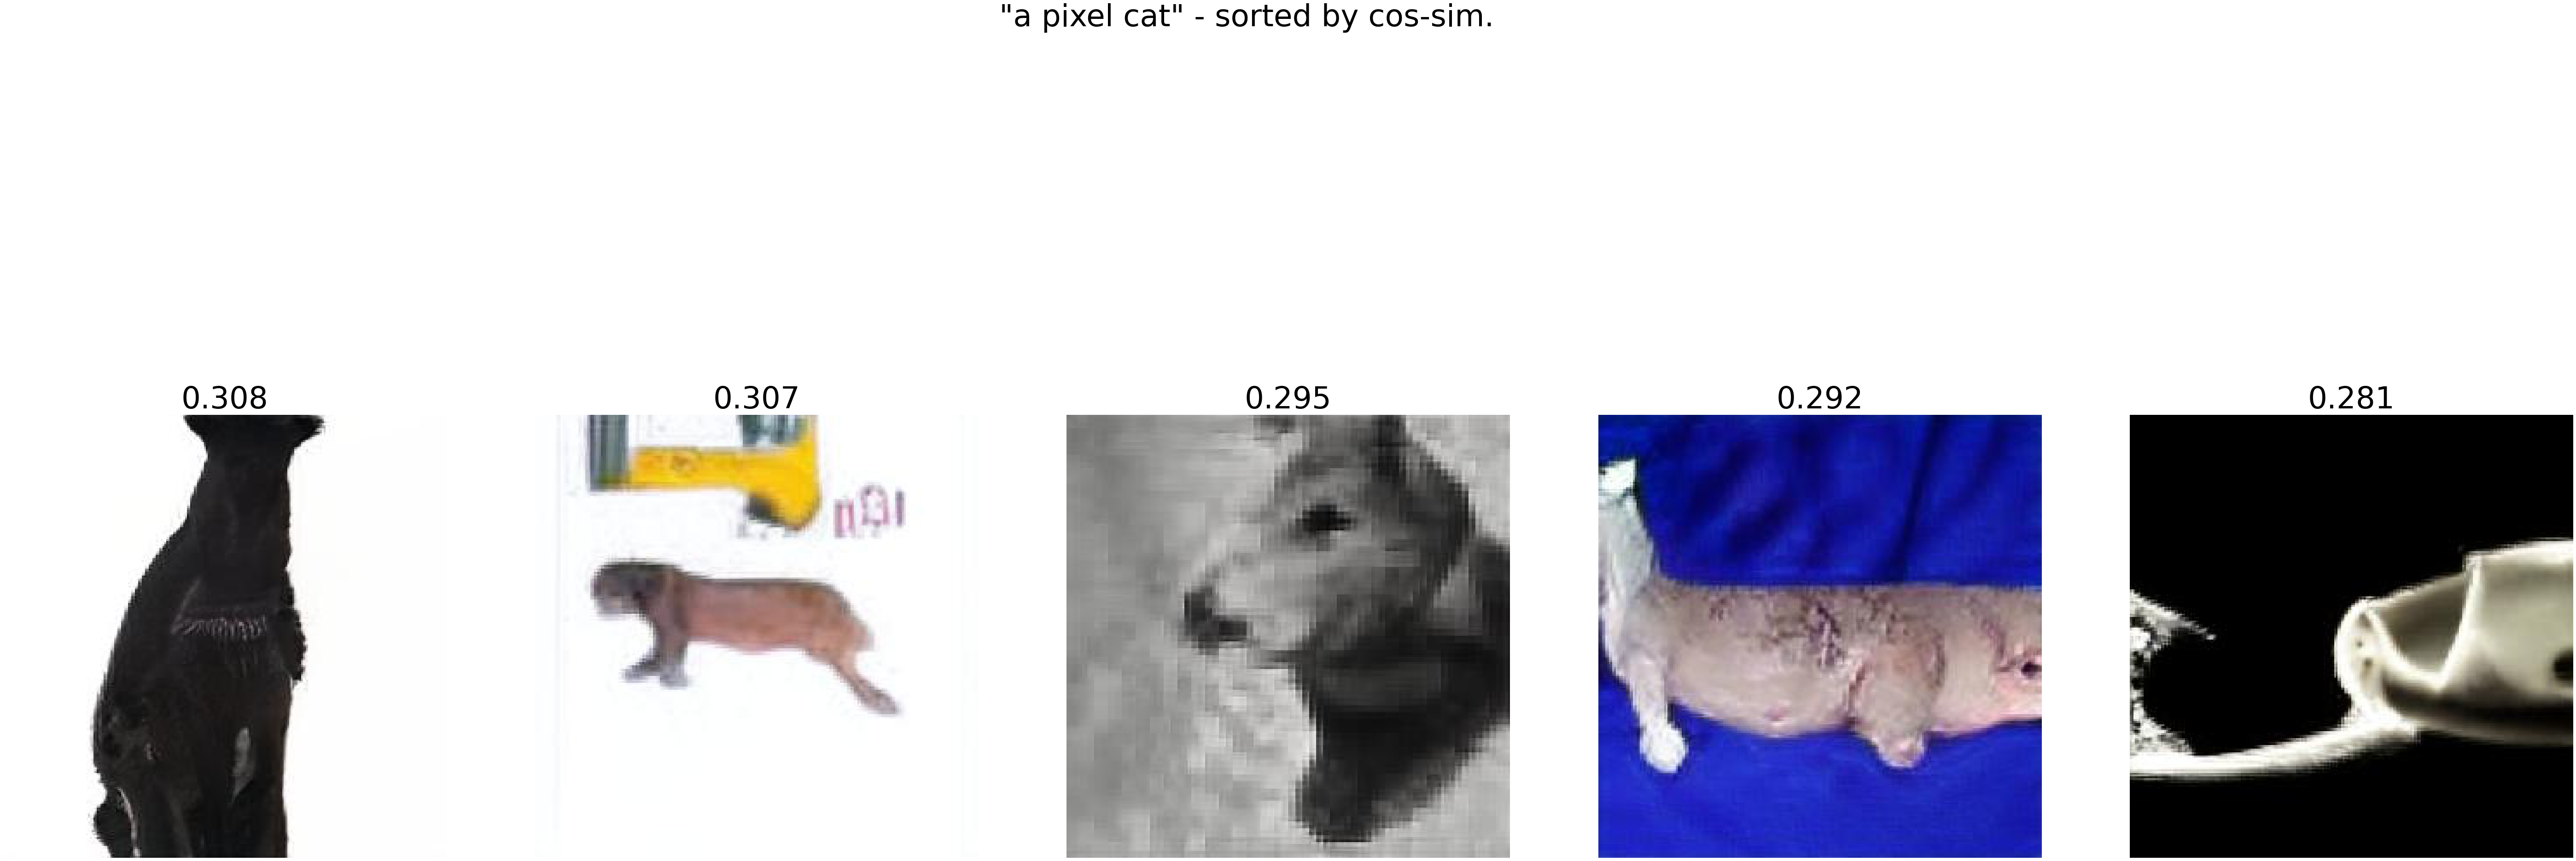

In [13]:
#@title SORT BY COSINE-SIMILARITY
import matplotlib.pyplot as plt
import PIL

cos_sim_dict_sorted = sorted(cos_sim_dict.items(), key=lambda x:x[1], reverse=True)

plt.rcParams["figure.figsize"] = (100,40)
plt.rcParams.update({'font.size': 55})
fig, ax = plt.subplots(1, len(cos_sim_dict_sorted))
for i, img_data in enumerate(cos_sim_dict_sorted):
  img = PIL.Image.open(img_data[0])
  ax[i].imshow(img) 
  ax[i].axis('off')
  ax[i].set_title(f'{round(float(img_data[1]), 3)}')
fig.suptitle(f'"{target}" - sorted by cos-sim.')
fig.show()